# Time Series

In [2]:
import pandas as pd
import numpy as np
import time as tm
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

In [5]:
#!wget 

In [14]:
# load the data as time series format: 
# data can be downloaded from Kaggle: https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne
# header=0, 
# parse_dates=True give the function a hint that data in the first column contains dates that need to be pased
# index_col=0 the first columns contains the index information for the time series model
# squeeze=True: only have one data columns 

series = pd.read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

df = pd.DataFrame()
df['month'] = [series.index[i].month for i in range(len(series))]
df['day'] = [series.index[i].day for i in range(len(series))]
df['temperature'] = [series[i] for i in range(len(series))] 

In [13]:
df.head()

,month,day,temperature
0,1,1,20.7
1,1,2,17.9
2,1,3,18.8
3,1,4,14.6
4,1,5,15.8


## Goal of Feature Engineering in Time Series Forecasting Models

The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model. 

Complexity exists in the relationship between the input and output data. In the case of time series, there is no input or output variables, and we need to invent these two and frame the supervised learning problem from scratch. 

The difficulty is that we dont know the underlying functional relationship between inputs and outputs that we are trying to expose. 

### Lag Feature:

In [30]:
temps = pd.DataFrame(series.values)
df = pd.concat([temps.shift(1), temps], axis=1)
df.columns = ['t', 't+1']

df.head()

,t,t+1
0,NaN,20.7
1,20.7,17.9
2,17.9,18.8
3,18.8,14.6
4,14.6,15.8


In [20]:
## multiple steps
df2 = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
df2.columns = ['t-2', 't-1', 't', 't+1']
df2.head()

,t-2,t-1,t,t+1
0,NaN,NaN,NaN,20.7
1,NaN,NaN,20.7,17.9
2,NaN,20.7,17.9,18.8
3,20.7,17.9,18.8,14.6
4,17.9,18.8,14.6,15.8


### Rolling Window Statistics

In [22]:
shift = temps.shift(1)
window = shift.rolling(window=2)
means = window.mean()
df3 = pd.concat([means, temps], axis=1)
df3.columns =['mean(t-1,1)', 't+1']

df3.head()

,"mean(t-1,1)",t+1
0,NaN,20.7
1,NaN,17.9
2,19.30,18.8
3,18.35,14.6
4,16.70,15.8


Other statistics that can be used to calculate the definition of the window:

In [26]:
width = 3
shift = temps.shift(width-1)
window = shift.rolling(window=width)
df4 = pd.concat([window.min(), window.mean(), window.max(), temps],
               axis=1)
df4.columns=['min', 'mean', 'max', 't+1']

In [28]:
df4.head(8)

,min,mean,max,t+1
0,NaN,NaN,NaN,20.7
1,NaN,NaN,NaN,17.9
2,NaN,NaN,NaN,18.8
3,NaN,NaN,NaN,14.6
4,17.9,19.133333,20.7,15.8
5,14.6,17.100000,18.8,15.8
6,14.6,16.400000,18.8,15.8
7,14.6,15.400000,15.8,17.4


### Expanding Window Statistics

Another type of window is including all previous data in the series, which can help track the bounds of data. Pandas provides 'expanding()' function that collects sets of all prior values for each time step.

In [29]:
window = temps.expanding()
df5 = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
df5.columns = ['min', 'mean', 'max', 't+!']
df5

,min,mean,max,t+!
0,20.7,20.700000,20.7,17.9
1,17.9,19.300000,20.7,18.8
2,17.9,19.133333,20.7,14.6
3,14.6,18.000000,20.7,15.8
4,14.6,17.560000,20.7,15.8
...,...,...,...,...
3645,0.0,11.174712,26.3,13.6
3646,0.0,11.175377,26.3,13.5
3647,0.0,11.176014,26.3,15.7
3648,0.0,11.177254,26.3,13.0


## Data Visualization

Visualization of time series is important to explore and understand the characteristics of time series dataset. Usually we use plots such as line plots, lag plots, autocorrelation plots, histograms, density, box and whisker plots, and heatmap plots. 

### Line Plot

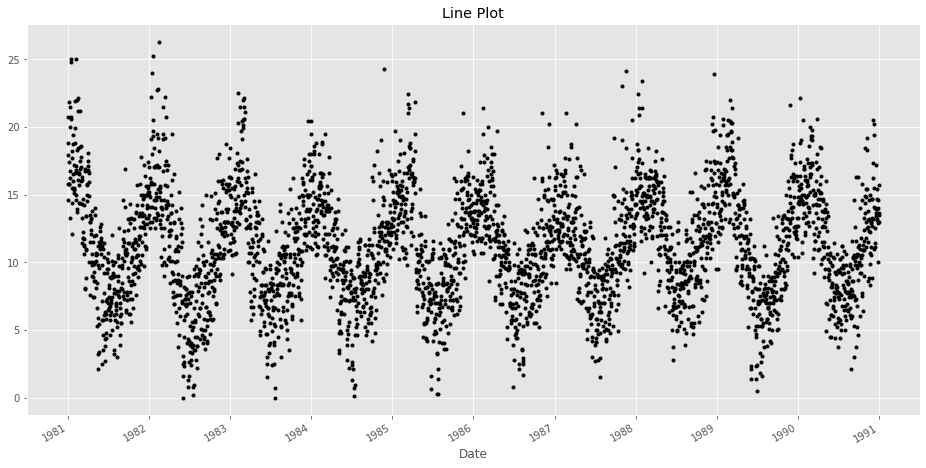

In [45]:
series.plot(figsize=(16, 8), style='k.')
plt.title('Line Plot')
plt.show()

line plot by years.

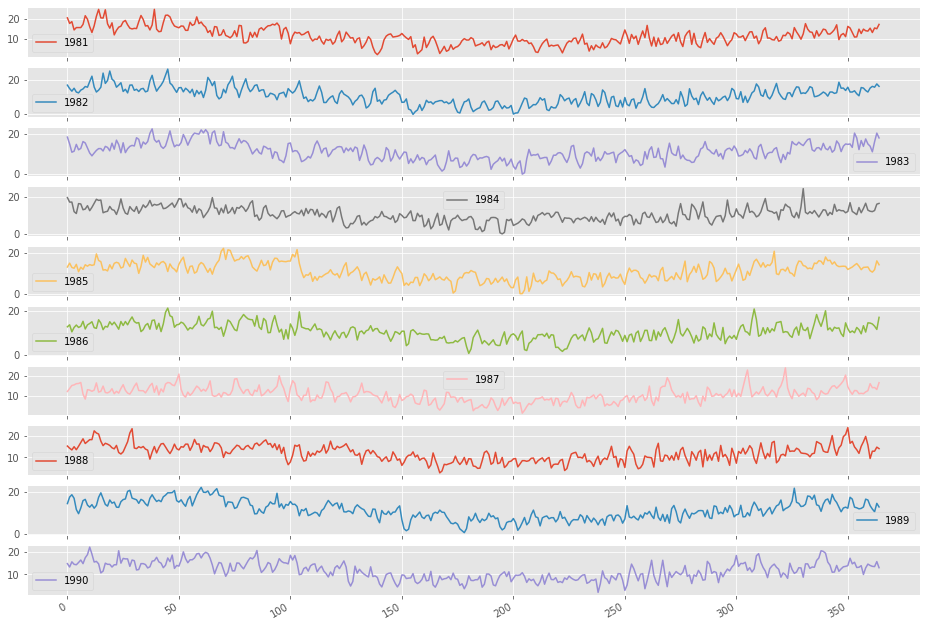

In [49]:
groups = series.groupby(pd.Grouper(freq='A'))

years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots=True, figsize=(16, 12))
plt.show()

Histogram and density plots

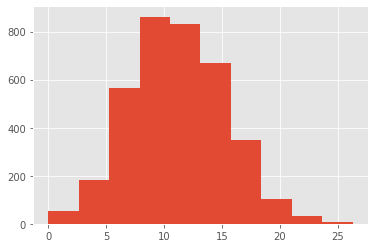

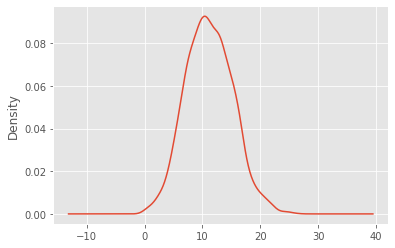

In [79]:
series.hist()
plt.show()
series.plot(kind='kde')
plt.show()

Box and whisker plots by interval

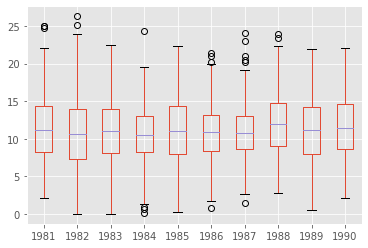

In [81]:
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()

for name, group in groups:
    years[name.year]=group.values
years.boxplot()
plt.show()

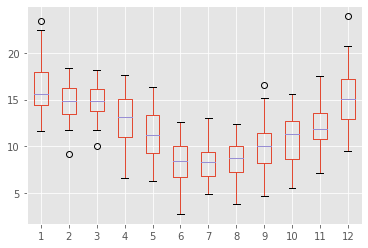

In [83]:
one_year = series['1988']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months.columns = range(1,13)
months.boxplot()

Heatmap

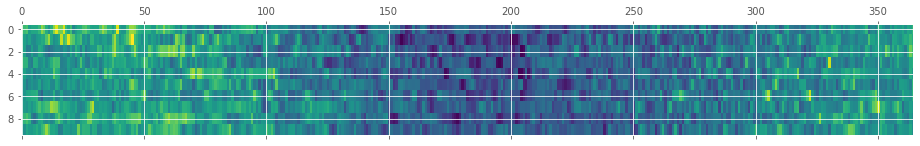

In [88]:
years = years.T
plt.matshow(years, interpolation=None, aspect='auto')
plt.show()


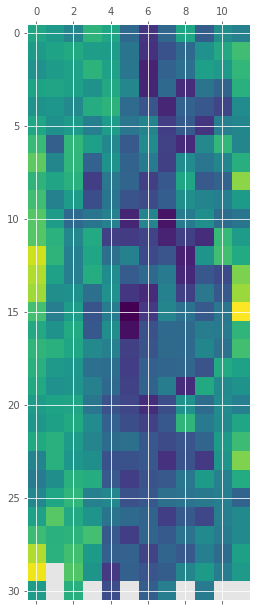

In [89]:
plt.matshow(months, interpolation=None, aspect='auto')
plt.show()

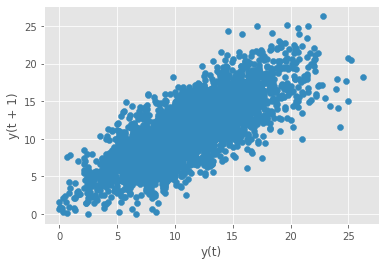

In [91]:
pd.plotting.lag_plot(series)

## Autocorrelation plot

Autocorrelation means the current observation and its prior observation has a correlation because of the time. The resulting plot shows that the dataset cycles of strong negative and positive correlation. This captures the relationship of an observation with lag observations in the same and opposite seasons or times of year. It indicates a storng sign of seasonality. 

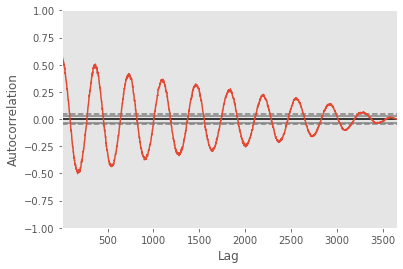

In [92]:
pd.plotting.autocorrelation_plot(series)

## Resampling and Interplotation

Resampling involves changing the frequency of time series observations. 

Upsampling: Where you incerase the frequency of the samples, such as from minutes to seconds.

Downsampling: Where you decrease the frequency of the samples, such as from days to months.

Reasons for resampling:
1. Problem Framing: resampling may be required if your data is not available at the same frequency that you want to make predictions.

2. Feature engineering: resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models. 

Use pandas resample() to resamle the data with Nan, then use pandas interplolate to interpolate values in the resampled series. There are two interpolation methods, linear interpolation or polynomial interpolation.

In [6]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [8]:
unsampled = series.resample('D').mean()
unsampled.head(30)

Month
1901-01-01    266.0
1901-01-02      NaN
1901-01-03      NaN
1901-01-04      NaN
1901-01-05      NaN
1901-01-06      NaN
1901-01-07      NaN
1901-01-08      NaN
1901-01-09      NaN
1901-01-10      NaN
1901-01-11      NaN
1901-01-12      NaN
1901-01-13      NaN
1901-01-14      NaN
1901-01-15      NaN
1901-01-16      NaN
1901-01-17      NaN
1901-01-18      NaN
1901-01-19      NaN
1901-01-20      NaN
1901-01-21      NaN
1901-01-22      NaN
1901-01-23      NaN
1901-01-24      NaN
1901-01-25      NaN
1901-01-26      NaN
1901-01-27      NaN
1901-01-28      NaN
1901-01-29      NaN
1901-01-30      NaN
Freq: D, Name: Sales, dtype: float64

Month
1901-01-01    266.000000
1901-01-02    262.125806
1901-01-03    258.251613
1901-01-04    254.377419
1901-01-05    250.503226
                 ...    
1903-11-27    638.153333
1903-11-28    640.340000
1903-11-29    642.526667
1903-11-30    644.713333
1903-12-01    646.900000
Freq: D, Name: Sales, Length: 1065, dtype: float64


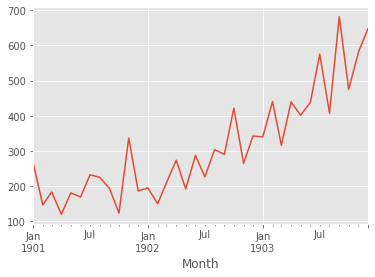

In [12]:
# interpolation method using linear interpolation, which draws a straight line
interpolated = unsampled.interpolate(method='linear')
print(interpolated)
interpolated.plot()
plt.show()

Month
1901-01-01    266.000000
1901-01-02    258.630160
1901-01-03    251.560886
1901-01-04    244.720748
1901-01-05    238.109746
                 ...    
1903-11-27    645.060131
1903-11-28    645.754167
1903-11-29    646.316013
1903-11-30    646.745668
1903-12-01    646.900000
Freq: D, Name: Sales, Length: 1065, dtype: float64


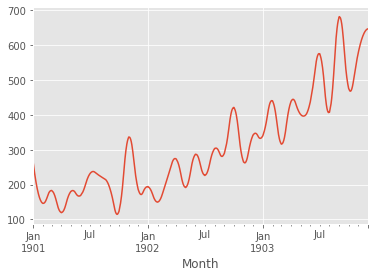

In [14]:
# Another interpolation method is polynomial or spline to connect the values. 
# This create curves and can look more natural on many dataset
# Using a spline interpolation requires specifying the order, which is the number of terms in the polynomial, normally 2 is fine.

interpolated2 = unsampled.interpolate(method='spline', order=2)
print(interpolated2)
interpolated2.plot()
plt.show()

### Downsamping

Month
1901-03-31    198.333333
1901-06-30    156.033333
1901-09-30    216.366667
1901-12-31    215.100000
1902-03-31    184.633333
Freq: Q-DEC, Name: Sales, dtype: float64


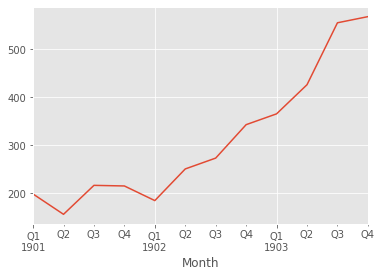

In [15]:
resample = series.resample('Q')
quarterly_mean_sales = resample.mean()
print(quarterly_mean_sales.head())
quarterly_mean_sales.plot()
plt.show()

Month
1901-12-31    2357.5
1902-12-31    3153.5
1903-12-31    5742.6
Freq: A-DEC, Name: Sales, dtype: float64


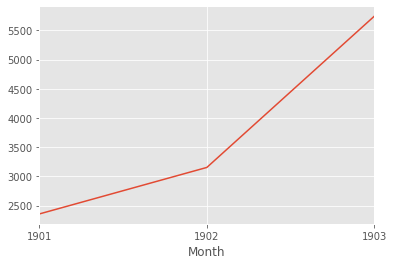

In [17]:
resample = series.resample('A')
yearly_mean_sales = resample.sum()
print(yearly_mean_sales.head())
yearly_mean_sales.plot()
plt.show()

## Power transforms

Data transforms are intended to remove noise and imporve the signal in time series forecasting. It can be very difficult to select a good, or best transform for a given prediction problem. 

1. Square root transform
2. Log transform
3. Box-Cox transform to perform square root, log, and automatically discover the best power transform 


In [18]:
series = pd.read_csv('airline-passengers.csv', 
                     header=0, 
                     index_col=0,
                    parse_dates=True,
                    squeeze=True)

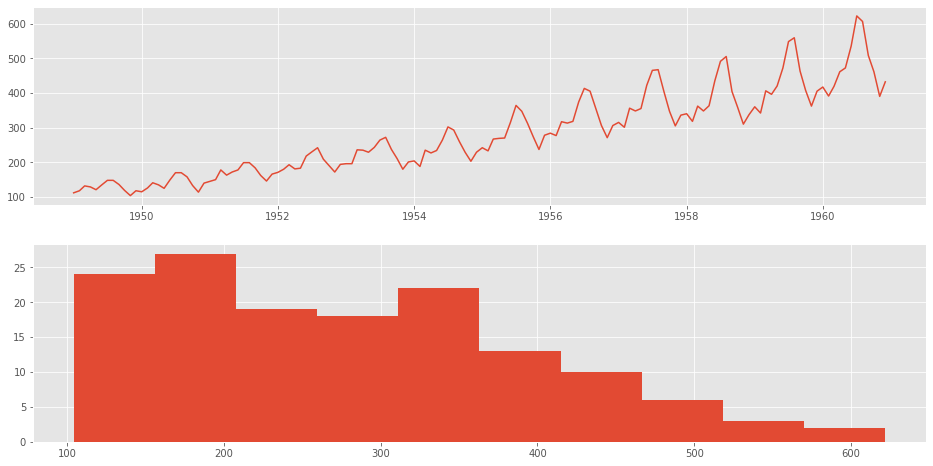

In [21]:
plt.figure(1, figsize=(16, 8))
plt.subplot(211)
plt.plot(series)

plt.subplot(212)
plt.hist(series)

plt.show()

This dataset is non-stationary, which means the mean and the variance of the observations change over time. 

The amount of cahnge, or the variance is increasing with time. The size of the seasonal component from one cycle to the next, the amplitude is increasing. 

### Square Root Transform

A time series that has a quadratic growth trend can be made linear by taking the square root. 

(array([315., 131., 101.,  84.,  75.,  67.,  62.,  58.,  54.,  52.]),
 array([1.00000e+00, 9.98010e+04, 1.99601e+05, 2.99401e+05, 3.99201e+05,
        4.99001e+05, 5.98801e+05, 6.98601e+05, 7.98401e+05, 8.98201e+05,
        9.98001e+05]),
 <a list of 10 Patch objects>)

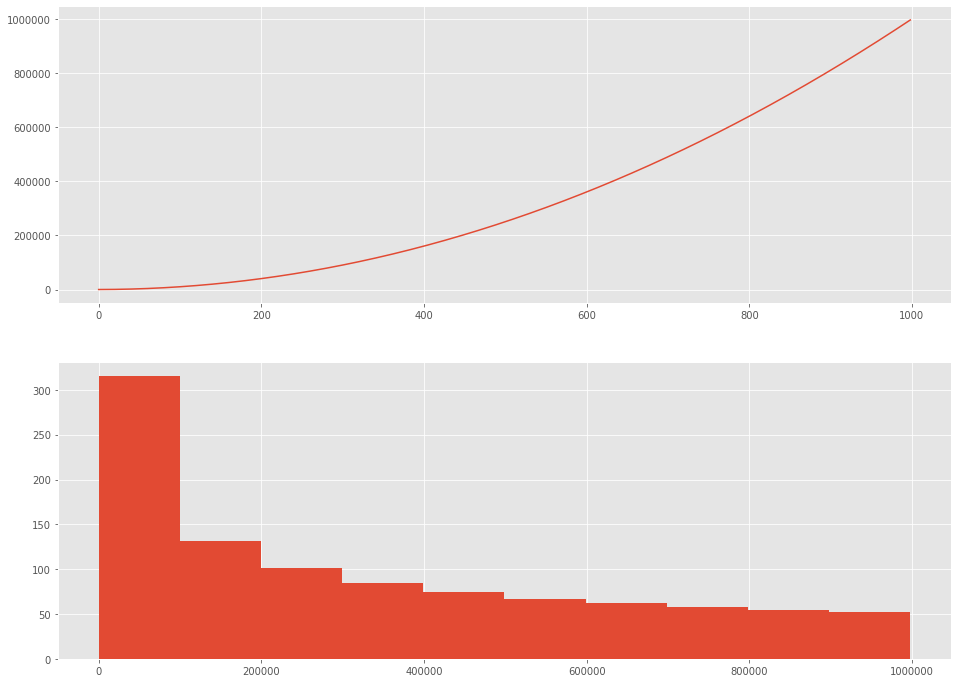

In [26]:
series = [i**2 for i in range(1,1000)]
plt.figure(1, figsize=(16, 12))
plt.subplot(211)
plt.plot(series)

plt.subplot(212)
plt.hist(series)

(array([100., 100., 100., 100.,  99., 100., 100., 100., 100., 100.]),
 array([  1. , 100.8, 200.6, 300.4, 400.2, 500. , 599.8, 699.6, 799.4,
        899.2, 999. ]),
 <a list of 10 Patch objects>)

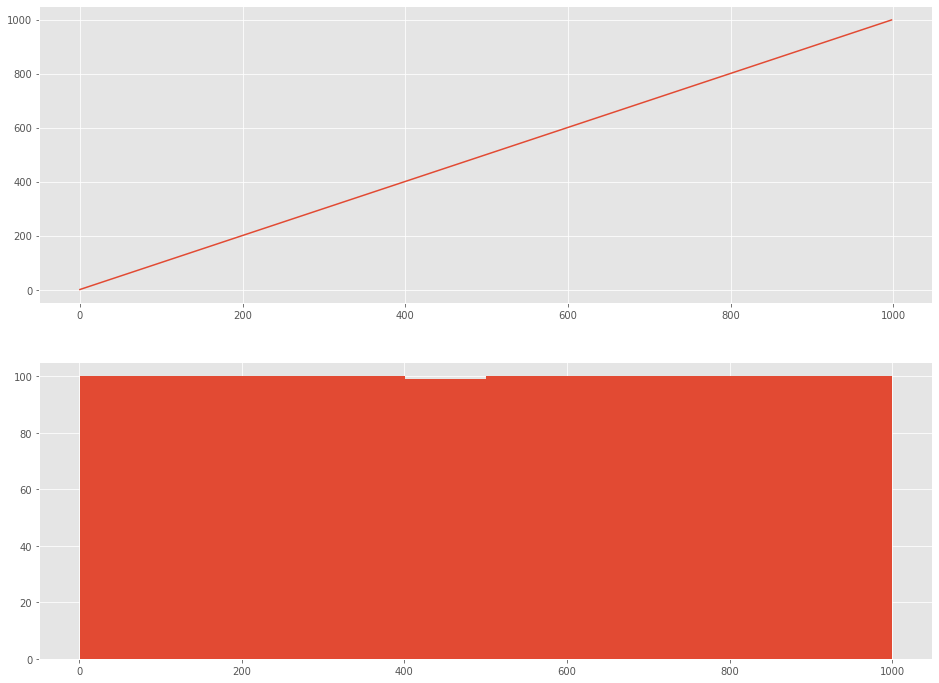

In [27]:
transform = series = np.sqrt(series)

plt.figure(1, figsize=(16, 12))
plt.subplot(211)
plt.plot(transform)

plt.subplot(212)
plt.hist(transform)

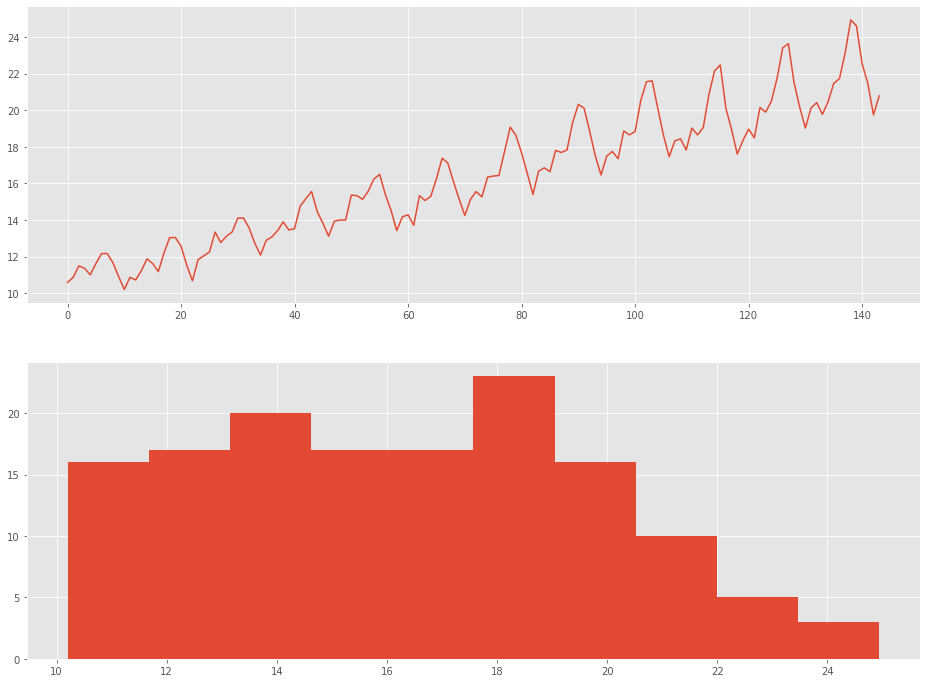

In [29]:
series = pd.read_csv('airline-passengers.csv',
                    header=0,
                    index_col=0,
                    parse_dates=True,
                    squeeze=True)
df = pd.DataFrame(series.values)
df.columns = ['passengers']
df['passengers'] = np.sqrt(df['passengers'])

plt.figure(1, figsize=(16, 12))

plt.subplot(211)
plt.plot(df['passengers'])

plt.subplot(212)
plt.hist(df['passengers'])
plt.show()

The trend was reduced, but not removed. The line plot still shows an increasing variance from cycle to cycle. This histgram still shows a long tail to the right of the distribution, suggesting an exponential or long-tail distribution.

## Log transform

Log transform is taking the logarithm of the values with an exponential distribution. 

Log transform is popular with time series data as they are effective at removing exponential variance. This operation assumes values are positive and non-zero. It is common to transform observations by adding a fixed constant to ensure all input values meet this requirement:

transform=log(cosntant+x)

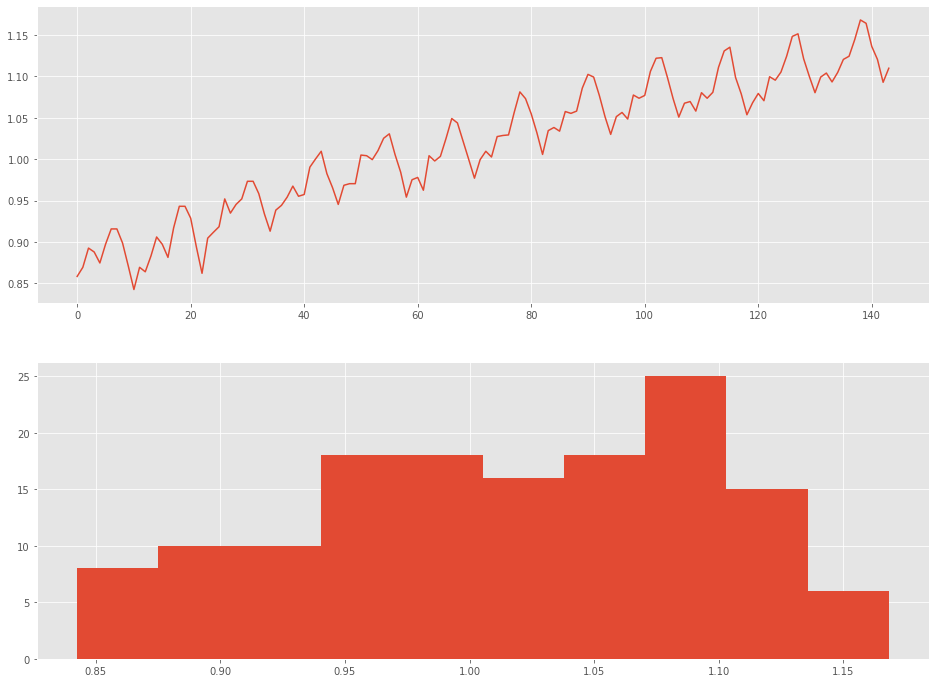

In [31]:
df['passengers']=np.log(df['passengers'])

plt.figure(1, figsize=(16, 12))
plt.subplot(211)
plt.plot(df['passengers'])

plt.subplot(212)
plt.hist(df['passengers'])

plt.show()

### Box-Cox Transform

The sqrt transform and log transfor belong to the family of power transform.

The Box-Cox transform is a configurable data transform method that supports both square root and log transform. More than that, it can be configured to evaluate a suite of transforms automatically and select a best fit. The resulting series may be more linear and the resulting distribution more Gaussian or Union. 

The scipy.stats library provides an implementation of the BOX-COX transform.The box-cox() function takes an argument of lambda, that controls the type of transform to perform.

1. lambda = -1.0. reciprocal transform
2. lambda = -0.5 reciprocal square root transform
3. lambda = 0.0 is a log transform
4. lambda = 0.5 is a square root transform
5. lambda = 1.0 is no transform

In [32]:
from scipy.stats import boxcox

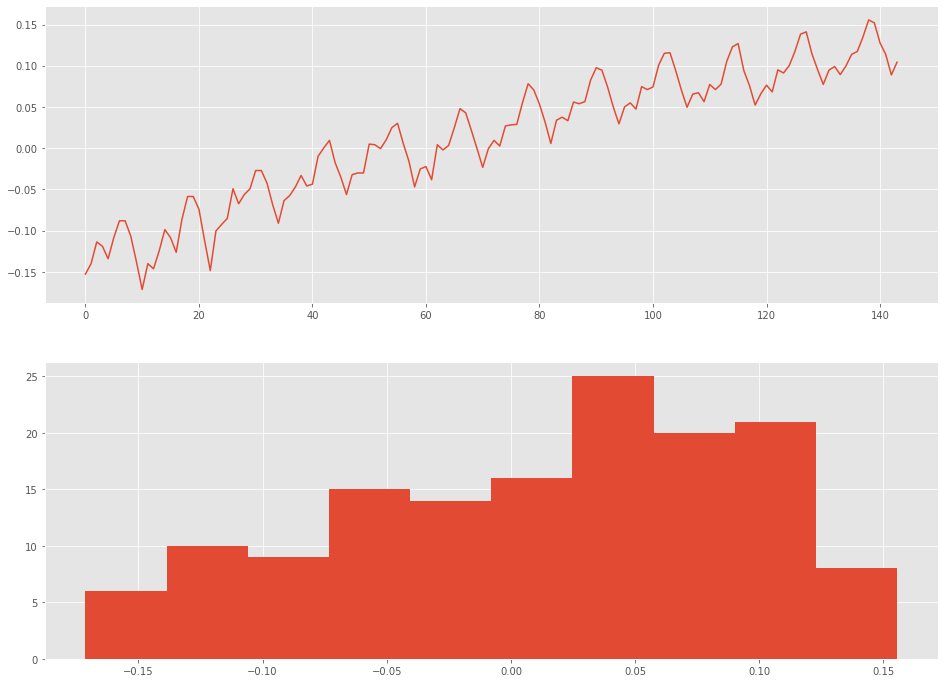

In [33]:
df['passengers'] = boxcox(df['passengers'], lmbda=0.0)

plt.figure(1, figsize=(16, 12))
plt.subplot(211)
plt.plot(df['passengers'])

plt.subplot(212)
plt.hist(df['passengers'])

plt.show()

lambda: 0.148023


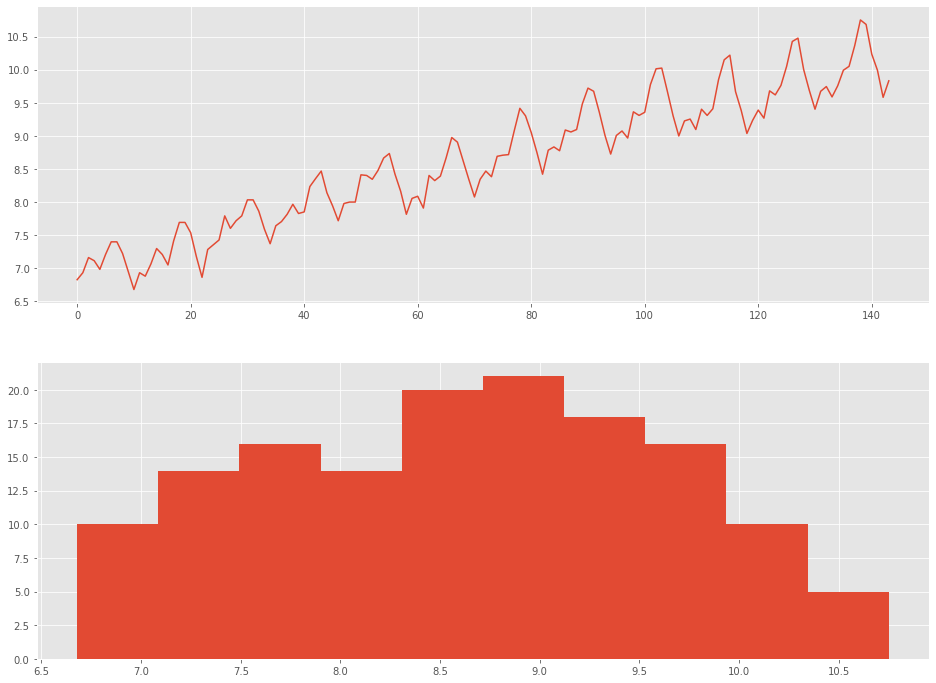

In [40]:
series = pd.read_csv('airline-passengers.csv',
                    header=0,
                    index_col=0,
                    parse_dates=True,
                    squeeze=True)
df = pd.DataFrame(series.values, columns=['passengers'])

df['passengers'], lam = boxcox(df['passengers'])
print('lambda: %f' %lam) 

plt.figure(1, figsize=(16, 12))

plt.subplot(211)
plt.plot(df['passengers'])

plt.subplot(212)
plt.hist(df['passengers'])

plt.show()